In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.optimizers import adam_v2
# import transbigdata as tbd
import warnings


In [2]:
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau

def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    model.add(Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))  # 将数据展平以适应输入层
    model.add(Dense(64, activation='relu'))  # 输入层
    model.add(Dense(32, activation='relu'))  # 隐藏层
    model.add(Dense(train_Y.shape[1]))  # 输出层

    adam = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    
    log = CSVLogger(f"./bp_50炼丹.csv", separator=",", append=True)
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[log, reduce])
    
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    
    model.save(f"./BP_50_model炼丹.h5")
    model.summary()
    return model


In [5]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

mmsi     updateDateFormat         lon  \
0  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:41:01  120.468625   
1  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:43:01  120.466964   
2  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:45:01  120.465346   
3  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:47:01  120.463671   
4  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:49:01  120.461955   

         lat  cog  sog  
0  30.736513  264  1.7  
1  30.736357  258  1.7  
2  30.736038  258  1.8  
3  30.735686  259  1.8  
4  30.735358  261  1.9

In [6]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [7]:
# 训练模型
# BP_model = trainModel(train_seq, train_label,test_seq,test_label)
BP_model  = load_model("./BP_50_model炼丹.h5")

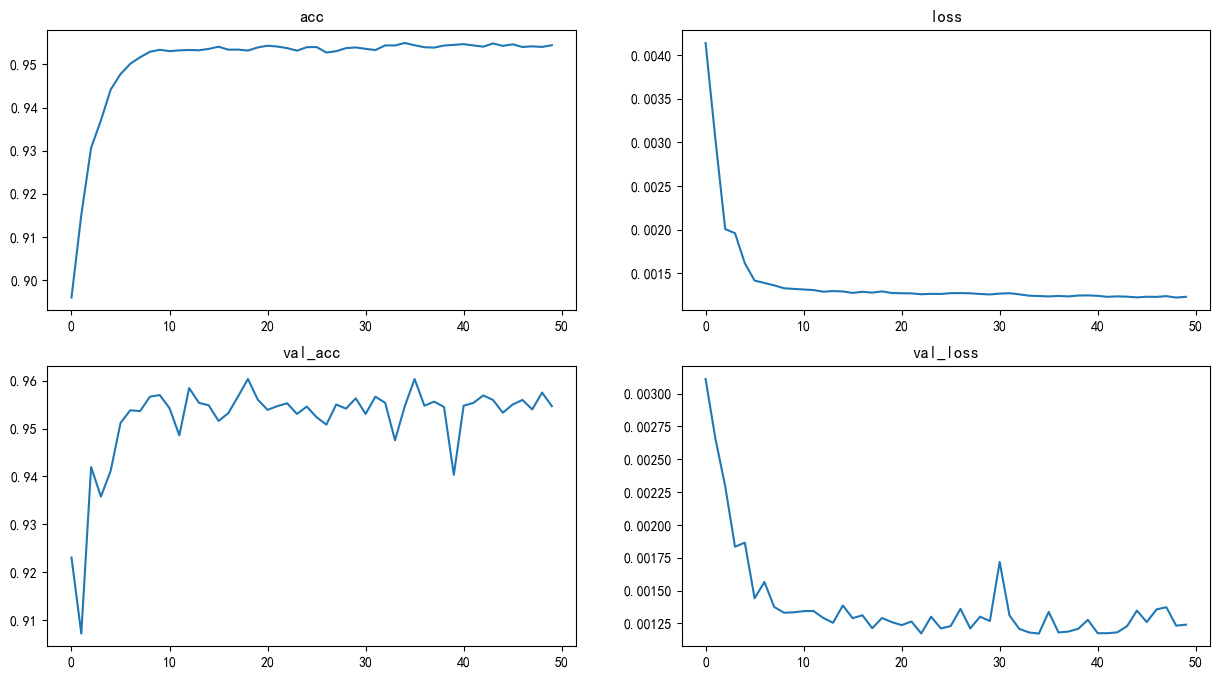

In [8]:
logs = pd.read_csv("./bp_50炼丹.csv")

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0][0].plot(logs['epoch'],logs['acc'], label='acc')
ax[0][0].set_title('acc')

ax[0][1].plot(logs['epoch'],logs['loss'], label='loss')
ax[0][1].set_title('loss')

ax[1][0].plot(logs['epoch'],logs['val_acc'], label='val_acc')
ax[1][0].set_title('val_acc')

ax[1][1].plot(logs['epoch'],logs['val_loss'], label='val_loss')
ax[1][1].set_title('val_loss')

plt.show()

1/1 [==============================] - 0s 13ms/step
最大值: 0.18291678321236254
最小值: 0.013206744798432011
均值: 0.06070869183072272
方差: 0.001210825053576417
标准差: 0.034796911552268786
中位数: 0.04830220311332881


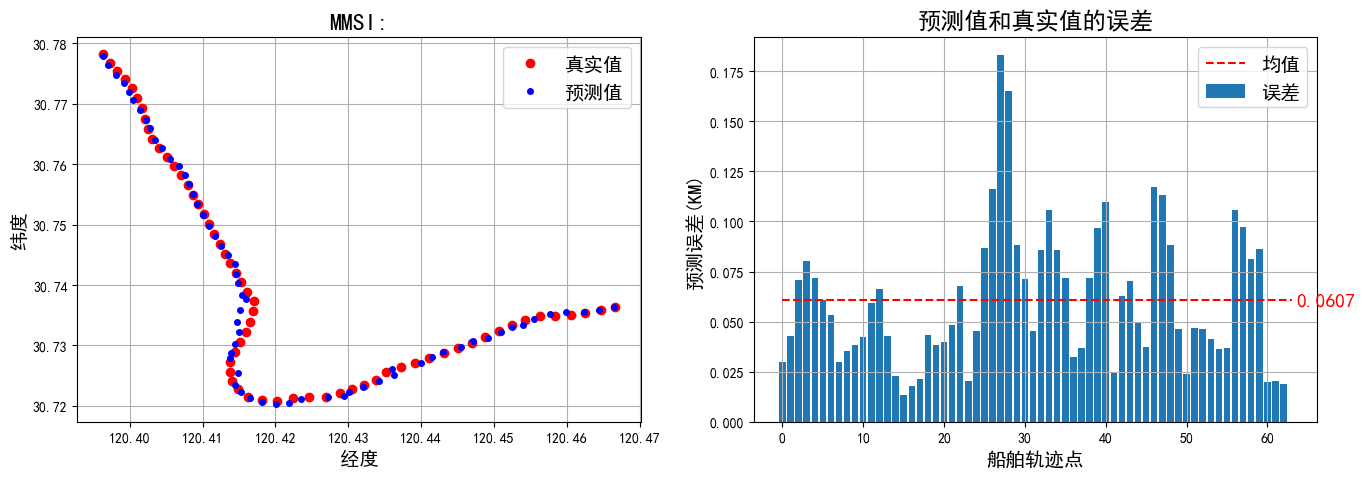

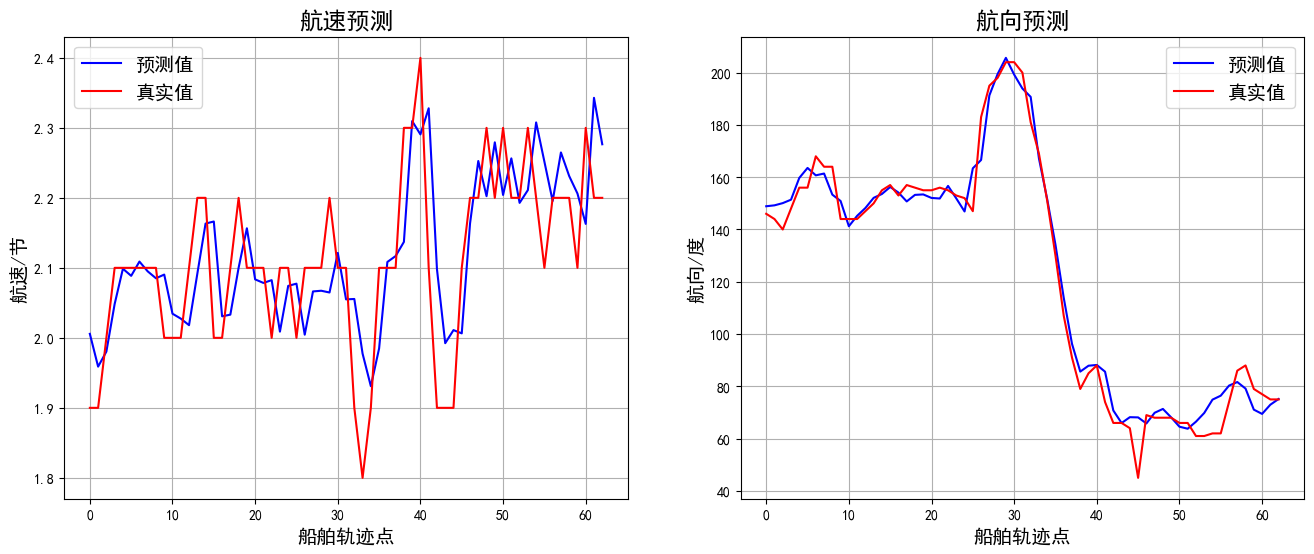

In [9]:
test_points_ids = list(set(test['mmsi']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = BP_model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')

    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
#     bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
#     tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

Processing sequence 0/63
1/1 [==============================] - 0s 18ms/step
Processing sequence 1/63
1/1 [==============================] - 0s 15ms/step
Processing sequence 2/63
1/1 [==============================] - 0s 15ms/step
Processing sequence 3/63
1/1 [==============================] - 0s 14ms/step
Processing sequence 4/63
1/1 [==============================] - 0s 13ms/step
Processing sequence 5/63
1/1 [==============================] - 0s 13ms/step
Processing sequence 6/63
1/1 [==============================] - 0s 13ms/step
Processing sequence 7/63
1/1 [==============================] - 0s 14ms/step
Processing sequence 8/63
1/1 [==============================] - 0s 14ms/step
Processing sequence 9/63
1/1 [==============================] - 0s 13ms/step
Processing sequence 10/63
1/1 [==============================] - 0s 16ms/step
Processing sequence 11/63
1/1 [==============================] - 0s 13ms/step
Processing sequence 12/63
1/1 [==============================] - 0s 13ms/s

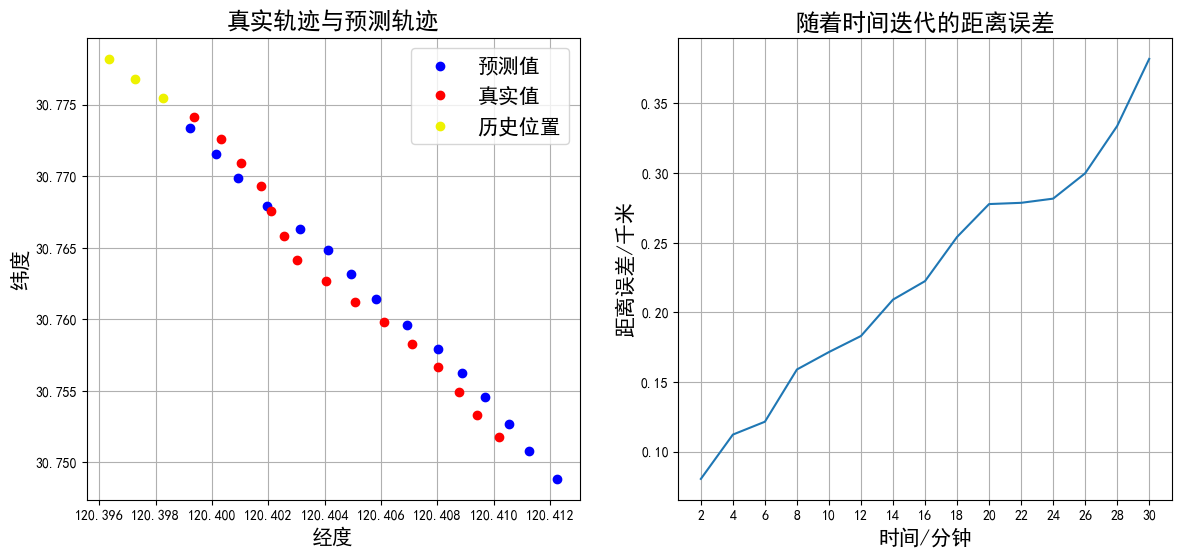

In [10]:
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        print(f"Processing sequence {i}/{len(test_seq)}")
        y_hat = BP_model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    for start_id in range(3,4):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        maxStep = min(15,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = BP_model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
#         bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
#         tbd.plot_map(plt,bounds,zoom = 16,style = 3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2,2*(maxStep)+1,2),f_y_pre[:,4])
        plt.xticks(np.arange(2,2*(maxStep)+1,2))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()

In [11]:
error_list = []
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 60
    for start_id in range(test_seq.shape[0]-int(pre_time/2)):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 循环预测
        for i in range(int(pre_time/2)):
            y_hat = BP_model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)
        error_list.append(list(f_y_pre[:,4]))

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


Text(0.5, 1.0, '整条轨迹上随时间变化的预测距离误差')

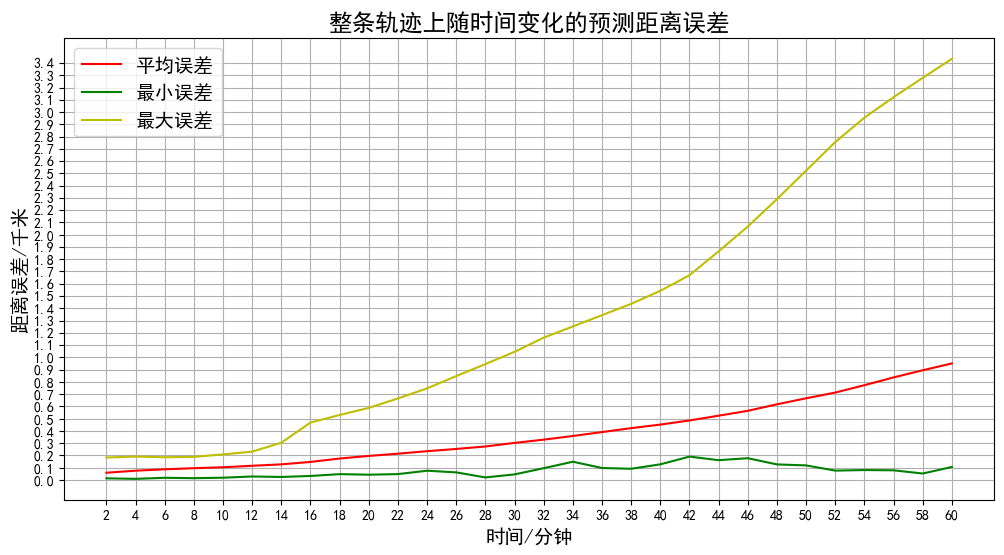

In [12]:
b = np.zeros([len(error_list),len(max(error_list,key = lambda x: len(x)))])
for i,j in enumerate(error_list):
    b[i][0:len(j)] = j

sums = b.sum(axis=0)
maxx = b.max(axis=0)
minx = []
means = []
for col in range(b.shape[1]):
    fzeros = b.shape[0] - list(b[:,col]).count(0.0)
    minx.append(min(list(b[:fzeros,col])))
    means.append(sums[col] / fzeros)

plt.figure(figsize=(12,6))
plt.plot(np.arange(2,2*(b.shape[1])+1,2),means,'-r',label='平均误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),minx,'-g',label='最小误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),maxx,'-y',label='最大误差')
plt.xticks(np.arange(2,2*(b.shape[1])+1,2))
plt.yticks(np.arange(0,max(maxx),0.1))
plt.xlabel("时间/分钟",fontsize=14)
plt.ylabel("距离误差/千米",fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title("整条轨迹上随时间变化的预测距离误差",fontsize=17)

In [13]:
print(means)

[0.05890989727323293, 0.0755572488054529, 0.08680032913362856, 0.095849871259181, 0.10343352208778821, 0.1155869196638577, 0.12719651670896734, 0.1469973621697437, 0.17463112355736352, 0.19607147997455635, 0.21423094379260332, 0.23469396549305072, 0.25277386515467865, 0.27303338358969353, 0.30216427161001624, 0.3286222412560146, 0.35863191335822553, 0.3904966447377442, 0.42243391585279333, 0.45152390773386386, 0.4852441779851608, 0.524053304813345, 0.5638824041452263, 0.6168963433977732, 0.6658628734991421, 0.7126635670388015, 0.7727589262082185, 0.8361334260976809, 0.8943253086811911, 0.950286437126697]


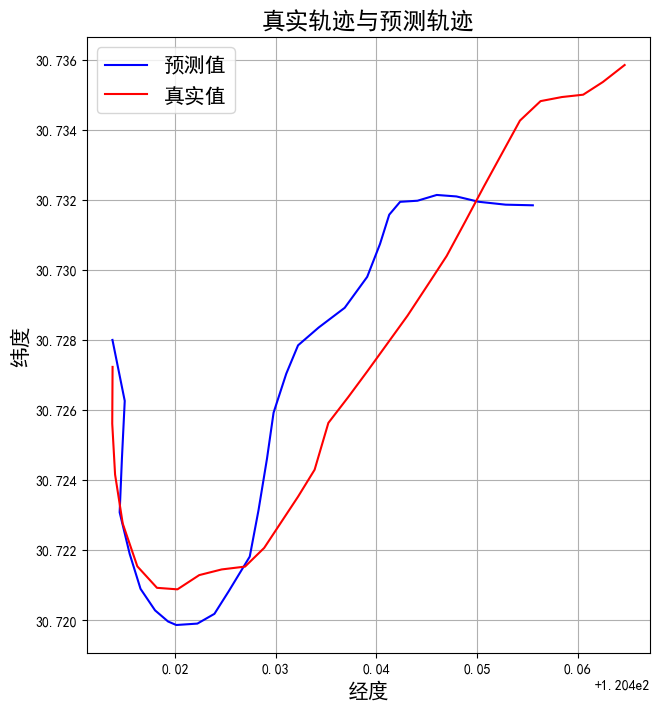

In [14]:

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "-b", label='预测值')
plt.plot(f_y_true[:, 0], f_y_true[:, 1], "-r", label='真实值')
# plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
# bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
# tbd.plot_map(plt,bounds,zoom = 16,style = 3)
plt.legend(fontsize=15)
plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
plt.title(f'真实轨迹与预测轨迹',fontsize=17)
plt.xlabel("经度",fontsize=15)
plt.ylabel("纬度",fontsize=15)
plt.grid()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import sklearn.metrics
mae = mean_absolute_error(f_y_true[:, 1], f_y_pre[:, 1])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 1], f_y_pre[:, 1])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 1], f_y_pre[:, 1])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 0.0012949843374151725
均方根误差（RMSE）: 0.0016708372839134096
R2分数（R2_score）: 0.8931059364990086


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import sklearn.metrics
mae = mean_absolute_error(f_y_true[:, 0], f_y_pre[:, 0])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 0], f_y_pre[:, 0])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 0], f_y_pre[:, 0])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 0.006105334986625621
均方根误差（RMSE）: 0.0070178406694858765
R2分数（R2_score）: 0.8069648729396618


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import sklearn.metrics
mae = mean_absolute_error(f_y_true[:, 2], f_y_pre[:, 2])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 2], f_y_pre[:, 2])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 2], f_y_pre[:, 2])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 0.1217849230766296
均方根误差（RMSE）: 0.14488683735654698
R2分数（R2_score）: 0.0628484089650665


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import sklearn.metrics
mae = mean_absolute_error(f_y_true[:, 3], f_y_pre[:, 3])
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(f_y_true[:, 3], f_y_pre[:, 3])
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(f_y_true[:, 3], f_y_pre[:, 3])
print(f"R2分数（R2_score）: {r2}")

平均绝对误差（MAE）: 10.481582781175772
均方根误差（RMSE）: 12.056406311897371
R2分数（R2_score）: 0.8568795622168657


In [19]:
print(f_y_pre[:, 0])

[120.41379935 120.4150187  120.41474083 120.41451303 120.41550635
 120.41658587 120.41802804 120.41932127 120.42013212 120.42222898
 120.42392109 120.42534457 120.42742967 120.42829551 120.42914051
 120.42979404 120.43105093 120.43222431 120.43427176 120.43685431
 120.43908754 120.44035932 120.44127584 120.44235472 120.44407931
 120.44599085 120.44794351 120.45016123 120.45283213 120.4555306 ]


In [20]:
f_y_pre[:, 1]

array([30.72800296, 30.72626185, 30.72462783, 30.72307978, 30.72189511,
       30.72089487, 30.7202801 , 30.71996194, 30.71986195, 30.71990211,
       30.72018059, 30.72082776, 30.72181639, 30.72313561, 30.72461322,
       30.72592611, 30.72703739, 30.72784908, 30.72835789, 30.72892062,
       30.72980415, 30.73074317, 30.73158018, 30.73194689, 30.73197838,
       30.7321432 , 30.732101  , 30.73194818, 30.73186582, 30.73184806])

In [21]:
f_y_true[:, 0]

array([120.41381083, 120.41377784, 120.41405928, 120.41481847,
       120.41626931, 120.41821773, 120.42024967, 120.42241433,
       120.42464438, 120.4269605 , 120.42886202, 120.43054326,
       120.43222449, 120.43386667, 120.4352345 , 120.43719283,
       120.43912001, 120.44111492, 120.44308772, 120.44508031,
       120.44697442, 120.44879425, 120.45068339, 120.45250589,
       120.45425289, 120.45629968, 120.45841362, 120.46052742,
       120.46248672, 120.46464417])

In [22]:
f_y_true[:, 1]

array([30.727233  , 30.72561165, 30.7241595 , 30.72275986, 30.72153681,
       30.72092368, 30.72088033, 30.721287  , 30.72144903, 30.72152986,
       30.72206374, 30.7227958 , 30.72352787, 30.724296  , 30.7256345 ,
       30.72636617, 30.72711503, 30.72790874, 30.72869449, 30.72956507,
       30.73039958, 30.73136927, 30.73239167, 30.73334938, 30.73426722,
       30.73482311, 30.73493948, 30.7350065 , 30.73536951, 30.73585444])